In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
#from scipy.special import boxcox1px
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.special as ss

In [3]:
%matplotlib inline

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train['SalePrice'].reset_index(drop=True)

In [6]:
test_ID = test.Id

In [7]:
train.drop('Id',inplace=True, axis=1)
test.drop('Id',inplace=True, axis=1)

In [8]:
print(train.shape, test.shape)

(1458, 80) (1459, 79)


In [9]:
data = pd.concat((train,test)).reset_index(drop=True)
print(data.shape)

(2917, 80)


In [10]:
data_nans = data.isnull().sum()
data_nans = data_nans[data_nans > 0]
data_nans.sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [11]:
strings = ['MSSubClass', 'YrSold', 'MoSold']
for var in strings:
    data[var] = data[var].apply(str)

In [12]:
groups = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for group in groups:
    mode = data[group].mode()[0]
    data[group] = data[group].fillna(mode)

    
data.MSZoning = data.MSZoning.fillna('RL')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    data[col] = data[col].fillna('None')
    
for col in ('GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF', 'GarageYrBlt'):
    data[col] = data[col].fillna(0)
    

data.Functional = data.Functional.fillna('Typ')

data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [13]:
data_nans = data.isnull().sum()
data_nans = data_nans[data_nans > 0]
data_nans.sort_values(ascending=False)

SalePrice    1459
dtype: int64

In [14]:
data.drop(['SalePrice'], axis=1, inplace=True)

In [15]:
data['TotalSF'] = data.TotalBsmtSF + data['1stFlrSF'] + data['2ndFlrSF']
data['TotalBath'] = data.FullBath + 0.5 * data.HalfBath + data.BsmtFullBath + 0.5 * data.BsmtHalfBath
data['TotalPorch'] = data.OpenPorchSF + data['3SsnPorch'] + data.EnclosedPorch + data.ScreenPorch + data.WoodDeckSF
data['YrBltAndRemod']=data.YearBuilt + data.YearRemodAdd

data['HasPool'] = data.PoolArea.apply(lambda x: 1 if x > 0 else 0)
data['HasGarage'] = data.GarageArea.apply(lambda x: 1 if x > 0 else 0)
data['HasBsmt'] = data.TotalBsmtSF.apply(lambda x: 1 if x > 0 else 0)
data['HasFirePl'] = data.Fireplaces.apply(lambda x: 1 if x > 0 else 0)

drops = ['Utilities', 'Street', 'PoolQC']
data = data.drop(drops,axis=1)

data.shape

(2917, 84)

In [16]:
cat_features = data.select_dtypes(include=['object']).columns
print(cat_features)
num_features = data.select_dtypes(exclude=['object']).columns
print(num_features)

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle',
       'SaleCondition', 'SaleType', 'YrSold'],
      dtype='object')
Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars',
       'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'Mas

In [17]:
feat_num = data[num_features]
feat_cat = data[cat_features]

In [18]:
skewness = feat_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          21.939672
PoolArea         17.688664
HasPool          15.494756
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
TotalPorch        1.379521
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
TotalSF           1.009157
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
TotalBath         0.486443
BedroomAbvGr      0.326568
GarageArea        0.216857
OverallQual       0.189591
FullBath          0.165514
HasFirePl        -0.052812
GarageCars       -0.219297
YrBltAndRemod    -0.303563
YearRemodAdd     -0.450134
Y

In [19]:
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
for feat in skewed_features:
    feat_num[feat] = ss.boxcox1p(feat_num[feat], boxcox_normmax(feat_num[feat] + 1))
    data[feat] = ss.boxcox1p(data[feat], boxcox_normmax(data[feat] + 1))

In [20]:
skewness = feat_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

print("There are {} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

There are 20 skewed numerical features after Box Cox transform
Mean skewnees: 3.261904729542875


PoolArea         15.595057
HasPool          15.494756
3SsnPorch         8.862045
LowQualFinSF      8.492615
MiscVal           5.237983
BsmtHalfBath      3.779434
KitchenAbvGr      3.778336
ScreenPorch       3.152631
BsmtFinSF2        2.578329
EnclosedPorch     2.149133
MasVnrArea        0.977618
2ndFlrSF          0.895453
WoodDeckSF        0.785550
HalfBath          0.732625
GarageYrBlt       0.701800
OpenPorchSF       0.621231
BsmtFullBath      0.616643
Fireplaces        0.553135
HasGarage        -3.939453
HasBsmt          -5.826825
dtype: float64

In [21]:
qual_dict = {"None": 0, "Po": 1, "Fa": 2, "TA": 4, "Gd": 7, "Ex": 11}
qual_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", 
             "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]

for cat in data.columns:
    if cat in qual_cols:
        data[cat] = data[cat].map(qual_dict).astype('int64')

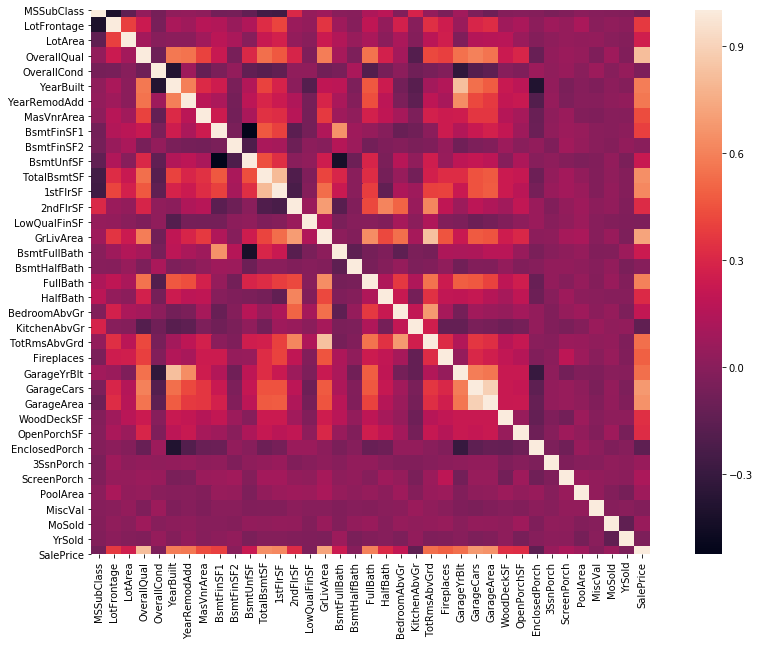

In [22]:
corr_matrix = train.corr()
f, ax = plt.subplots(figsize=(16,10))
sns.heatmap(corr_matrix, vmax=1, square=True);

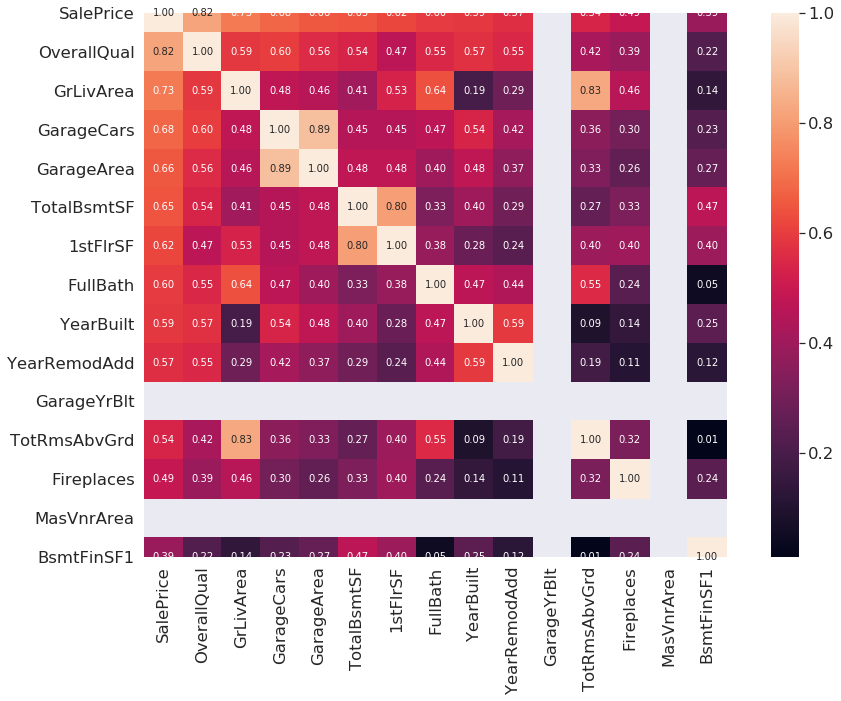

In [23]:
corr_num = 15
cols_corr = corr_matrix.nlargest(corr_num, 'SalePrice')['SalePrice'].index
corr_mat_sales = np.corrcoef(train[cols_corr].values.T)
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(16,10))
hm = sns.heatmap(corr_mat_sales,cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},yticklabels=cols_corr.values, xticklabels=cols_corr.values)
plt.show()

In [24]:
fin_data = pd.get_dummies(data).reset_index(drop=True)

In [25]:
print(fin_data.shape)
train = fin_data.iloc[:len(y),:]
test = fin_data.iloc[len(y):,:]
print(train.shape,y.shape,test.shape)

(2917, 294)
(1458, 294) (1458,) (1459, 294)


In [26]:
outliers = [30, 88, 462, 631, 1322]
train = train.drop(train.index[outliers])
y_train = y.drop(y.index[outliers])

In [27]:
print(train.shape,y_train.shape,test.shape)

(1453, 294) (1453,) (1459, 294)


In [28]:
y = y_train.values

In [29]:
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [30]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [31]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.00057, random_state=1))

In [32]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [33]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [34]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [35]:
model_xgb_deep = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [36]:
model_lgb_estimatorsH = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =4, min_sum_hessian_in_leaf = 11)

In [37]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1016 (0.0050)

ElasticNet score: 0.1018 (0.0050)

Xgboost score: 0.1083 (0.0045)

LGBM score: 0.1082 (0.0045)



In [38]:
score = rmsle_cv(model_xgb_deep)
print("Deep XGB: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Deep XGB: 0.1082 (0.0041)



In [39]:
score = rmsle_cv(model_lgb_estimatorsH)
print("model_lgb_estimatorsH: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

model_lgb_estimatorsH: 0.1084 (0.0049)



In [40]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [41]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [42]:
averaged_models = AveragingModels(models = (ENet, model_xgb, model_lgb,model_xgb_deep, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1014 (0.0045)



In [43]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, 
                                                                model_xgb_deep, 
                                                                model_xgb, 
                                                                model_lgb, 
                                                                model_lgb_estimatorsH),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1001 (0.0049)


In [44]:
stacked_averaged_models2 = StackingAveragedModels(base_models = (lasso, 
                                                                model_xgb_deep, 
                                                                model_xgb, 
                                                                model_lgb, 
                                                                model_lgb_estimatorsH),
                                                 meta_model = ENet)

score = rmsle_cv(stacked_averaged_models2)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1001 (0.0048)


In [45]:
averaged_models.fit(train.values, y)
averaged_models_train_pred = averaged_models.predict(train.values)
averaged_models_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y, averaged_models_train_pred))

0.07641836837089228


In [46]:
stacked_averaged_models.fit(train.values, y)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y, stacked_train_pred))

0.08003041471208078


In [47]:
model_xgb.fit(train, y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y, xgb_train_pred))

0.07625258657743952


In [48]:
model_lgb.fit(train, y)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y, lgb_train_pred))

0.06673937473546523


In [49]:
lasso.fit(train, y)
lasso_train_pred = lasso.predict(train)
lasso_pred = np.expm1(lasso.predict(test.values))
print(rmsle(y, lasso_train_pred))

0.09202001231940841


In [80]:
ensemble = stacked_pred*0.317 + xgb_pred*0.218 + lasso_pred*0.251 + lgb_pred*0.214

In [81]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('ensemble calc submission.csv',index=False)

In [52]:
ref = pd.read_csv('best_submission.csv')
ref2 = pd.read_csv('res2.csv')

In [74]:
results = (lasso_pred, lgb_pred, xgb_pred, stacked_pred)

In [75]:
for res in results:
    print(rmsle(ref.SalePrice, res))

9862.658974519583
11536.781732288528
11364.893861258302
7802.8823970277235


In [77]:
# список моделей для ансамблЯ
names = 'lasso_pred, lgb_pred, xgb_pred, stacked_pred, averaged_models_pred, ensemble'
total = []
for res in results:
    total.append(rmsle(ref.SalePrice, res)) # посчитали их отклонение от лучшего сабмита    
total = 1/(total/sum(total))
total = total/sum(total) # преобразовали в доли
list(zip(names.split(','),total.round(3)))


[('lasso_pred', 0.251),
 (' lgb_pred', 0.214),
 (' xgb_pred', 0.218),
 (' stacked_pred', 0.317)]

In [79]:
sum((214, 251, 218,317))

1000